# Variational autoencoder for 1D data 

In this notebook, we will implement a variational autoencoder (VAE) for 1D data which was generated from the mixture of several Gaussian distributions. 

I follow the theory behind VAEs outlined in [Understanding Deep Learning](https://udlbook.github.io/udlbook/) by Simon J.D. Prince, chapter 17.

In [243]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.data import Dataset, DataLoader

import os
from tqdm import tqdm

%matplotlib inline

# 1D Data preparation

cpu


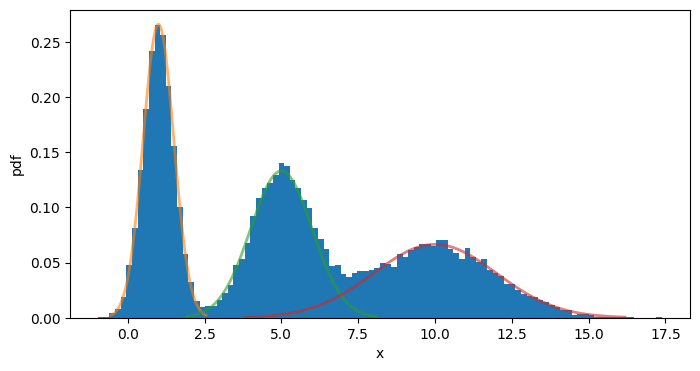

In [244]:
class MyDataset(Dataset):
    def __init__(self, means_list = [1, 5, 10], stds_list = [0.5, 1, 3], size = 10000, seed = 0):
        
        rvs_list = [stats.norm(loc=mean, scale=std) for mean, std in zip(means_list, stds_list)]

        np.random.seed(seed)
        x_train = np.concatenate([rvs.rvs(size) for rvs in rvs_list])
        
        #shuffle
        np.random.shuffle(x_train)

        self.x = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)
        self.x_numpy = x_train

        self.rvs_list = rvs_list
        self.n_rvs = len(rvs_list)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]
    
    def plot_data(self):
        fig,  ax =  plt.subplots( figsize = (8,4))
        ax.hist(self.x_numpy, bins = 100, density = True)

        for rvs in self.rvs_list:
            x = np.linspace(rvs.ppf(0.001), rvs.ppf(0.999), 100)
            ax.plot(x, rvs.pdf(x)/self.n_rvs, lw=2, alpha=0.6)
        ax.set_xlabel('x')
        ax.set_ylabel('pdf')
        plt.show()


BATCH_SIZE = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_dataset = MyDataset(means_list = [1, 5, 10],
                          stds_list = [0.5, 1, 2],
                            seed = 42)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
train_dataset.plot_data()

In [245]:
# sanity check of batch size and shape
one_batch = next(iter(train_loader))
one_batch.shape

torch.Size([25, 1])

In [246]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # mu layer
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # logvariance layer

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        h4 = torch.relu(self.fc4(h3))
        return self.fc5(h4)  # return linear output

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 1))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    


In [247]:
def train_vae(vae, train_loader, epochs=10, lr=0.001, kl_weight=1.0):
    optimizer = Adam(vae.parameters(), lr=lr)
    mse_loss = MSELoss()

    vae.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            mse = mse_loss(recon_batch, data)
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = mse + kl_weight * KLD
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset)}')

# Instantiate the VAE
vae = VAE(input_dim=1, hidden_dim=10, latent_dim=6)



In [248]:
# Train the VAE
train_vae(vae, train_loader, epochs=10, lr=4e-4, kl_weight=1)


====> Epoch: 0 Average loss: 1.1053344546000163
====> Epoch: 1 Average loss: 0.6104651333332062
====> Epoch: 2 Average loss: 0.6104372425079345
====> Epoch: 3 Average loss: 0.6059294611295064
====> Epoch: 4 Average loss: 0.6057068693478902
====> Epoch: 5 Average loss: 0.6023700680732728
====> Epoch: 6 Average loss: 0.6042753706296285
====> Epoch: 7 Average loss: 0.6062806732813517
====> Epoch: 8 Average loss: 0.6067230858167012
====> Epoch: 9 Average loss: 0.6026293484369913


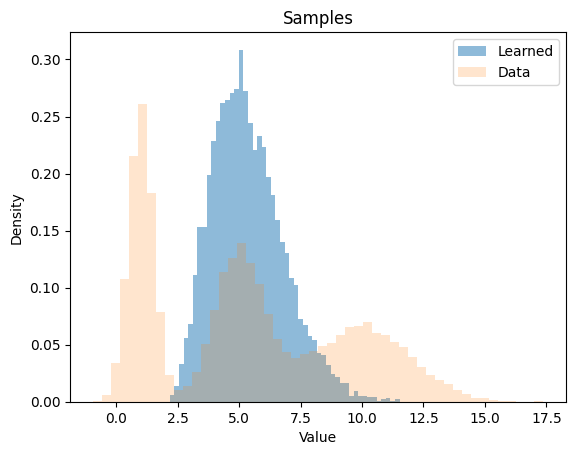

In [249]:
def generate_samples(vae, num_samples):
    # Sample from standard normal distribution
    z = torch.randn(num_samples, vae.fc21.out_features)

    # Generate samples by decoding the latent vector
    samples = vae.decode(z)

    return samples

def visualize_samples(samples, data=None, bins = 50):
    # Convert tensor to numpy array for visualization
    samples = samples.detach().numpy()

    # Create a histogram
    plt.hist(samples, bins=bins, density=True, alpha = 0.5)
    plt.xlabel('Value')
    plt.ylabel('Density')

    if data is not None:
        # Plot the data distribution
        data = data.numpy()
        plt.hist(data, bins=bins, density=True, alpha=0.2)
        plt.legend(['Learned', 'Data'])
    plt.title('Samples')
    plt.show()

# Generate 1000 samples
samples = generate_samples(vae, 10000)

# Visualize the samples
visualize_samples(samples, train_dataset.x)